## Задание

1. Загрузите выборку из файла gbm-data.csv с помощью pandas и преобразуйте ее в массив numpy (параметр values у датафрейма). В первой колонке файла с данными записано, была или нет реакция. Все остальные колонки (d1 - d1776) содержат различные характеристики молекулы, такие как размер, форма и т.д. Разбейте выборку на обучающую и тестовую, используя функцию train_test_split с параметрами test_size = 0.8 и random_state = 241.
2. Обучите GradientBoostingClassifier с параметрами n_estimators=250, verbose=True, random_state=241 и для каждого значения learning_rate из списка [1, 0.5, 0.3, 0.2, 0.1] проделайте следующее:
 - Используйте метод staged_decision_function для предсказания качества на обучающей и тестовой выборке на каждой итерации.
 - Преобразуйте полученное предсказание с помощью сигмоидной функции по формуле 1 / (1 + e^{−y_pred}), где y_pred — предсказанное значение.
 - Вычислите и постройте график значений log-loss (которую можно посчитать с помощью функции sklearn.metrics.log_loss) на обучающей и тестовой выборках, а также найдите минимальное значение метрики и номер итерации, на которой оно достигается.
3. Как можно охарактеризовать график качества на тестовой выборке, начиная с некоторой итерации: переобучение (overfitting) или недообучение (underfitting)? В ответе укажите одно из слов overfitting либо underfitting.

4. Приведите минимальное значение log-loss на тестовой выборке и номер итерации, на котором оно достигается, при learning_rate = 0.2.

5. На этих же данных обучите RandomForestClassifier с количеством деревьев, равным количеству итераций, на котором достигается наилучшее качество у градиентного бустинга из предыдущего пункта, c random_state=241 и остальными параметрами по умолчанию. Какое значение log-loss на тесте получается у этого случайного леса? (Не забывайте, что предсказания нужно получать с помощью функции predict_proba. В данном случае брать сигмоиду от оценки вероятности класса не нужно)



Загрузим данные, посмотрим на них

In [1]:
import pandas
data = pandas.read_csv('gbm-data.csv')

In [2]:
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Выделим целевую переменную, преобразуем данные в массив

In [3]:
y = data['Activity'].values
X = data.loc[:, 'D1':'D1776'].values

Разобъем выборку на обучающую и тестовую

In [5]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)

Ниже реализуем несколько функций для дальнейшей работы:
 - sigmoid(y_pred) - преобразует полученное предсказание с помощью сигмоидной функции. Получает на вход y_pred - предсказанное значение
 - log_loss_results(model, X, y) - получает на вход model (в нашем случае GradientBoostingClassifier), данные и целевую переменную. Возращает массив со значениями log-loss 
 - plot_loss(learning_rate, test_loss, train_loss) - принимает на вход значение learning_rate и выборки. Строит граффики функций значений log-loss на обучающей и тестовой выборках. Возращает минимальное значение log-loss на тестовой выборке и номер итерации, на котором оно достигается
 - model_test(learning_rate) - принимает на вход параметр learning_rate. Внутри происходит обучение GradientBoostingClassifier, вызов функции log_loss_results и построение графиков (вызов plot_loss).

In [6]:
import math

def sigmoid(y_pred):
    return 1.0 / (1.0 + math.exp(-y_pred))

In [7]:
from sklearn.metrics import log_loss

def log_loss_results(model, X, y):
    results = []
    for pred in model.staged_decision_function(X):
        results.append(log_loss(y, [sigmoid(y_pred) for y_pred in pred]))
    return results

In [8]:
import matplotlib.pyplot as plt

def plot_loss(learning_rate, test_loss, train_loss):
    plt.figure()
    plt.plot(test_loss, 'r', linewidth=2)
    plt.plot(train_loss, 'g', linewidth=2)
    plt.legend(['test', 'train'])
    plt.title('learning_rate = ' + str(learning_rate))
    plt.show()
    min_loss_value = min(test_loss)
    min_loss_index = test_loss.index(min_loss_value)
    return min_loss_value, min_loss_index

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

def model_test(learning_rate):
    model = GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=250, verbose=True, random_state=241)
    model.fit(X_train, y_train)
    train_loss = log_loss_results(model, X_train, y_train)
    test_loss = log_loss_results(model, X_test, y_test)
    return plot_loss(learning_rate, test_loss, train_loss)

Применим функцию model_test для ряда learning_rate [1, 0.5, 0.3, 0.2, 0.1] 

      Iter       Train Loss   Remaining Time 
         1           1.0190           15.94s
         2           0.9192           15.13s
         3           0.8272           14.08s
         4           0.7834           14.21s
         5           0.7109           14.06s
         6           0.6368           14.31s
         7           0.5797           14.16s
         8           0.5610           13.73s
         9           0.5185           13.66s
        10           0.4984           13.32s
        20           0.1999           12.32s
        30           0.1313           11.26s
        40           0.0790           10.60s
        50           0.0511            9.96s
        60           0.0352            9.46s
        70           0.0245            8.89s
        80           0.0162            8.39s
        90           0.0114            7.91s
       100           0.0077            7.46s
       200           0.0004            2.20s


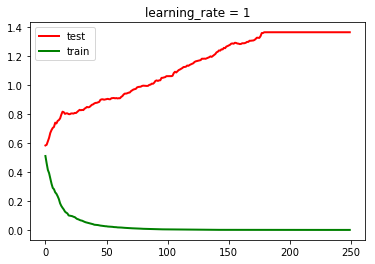

      Iter       Train Loss   Remaining Time 
         1           1.1255           15.69s
         2           1.0035           15.38s
         3           0.9386           15.31s
         4           0.8844           15.01s
         5           0.8381           14.70s
         6           0.7995           14.15s
         7           0.7559           13.82s
         8           0.7205           13.64s
         9           0.6958           13.50s
        10           0.6725           13.32s
        20           0.4672           12.28s
        30           0.3179           11.56s
        40           0.2274           10.93s
        50           0.1774           10.24s
        60           0.1394            9.65s
        70           0.1050            9.21s
        80           0.0805            8.72s
        90           0.0650            8.15s
       100           0.0511            7.66s
       200           0.0058            2.52s


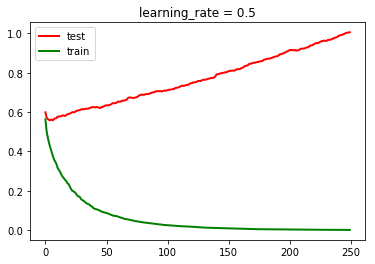

      Iter       Train Loss   Remaining Time 
         1           1.2095           14.94s
         2           1.1006           15.00s
         3           1.0240           14.82s
         4           0.9729           14.94s
         5           0.9387           14.31s
         6           0.8948           14.31s
         7           0.8621           13.99s
         8           0.8360           13.58s
         9           0.8171           13.66s
        10           0.7883           13.97s
        20           0.6164           12.39s
        30           0.4933           11.81s
        40           0.4248           11.04s
        50           0.3345           10.46s
        60           0.2760            9.89s
        70           0.2263            9.31s
        80           0.1971            8.79s
        90           0.1693            8.18s
       100           0.1388            7.69s
       200           0.0294            2.54s


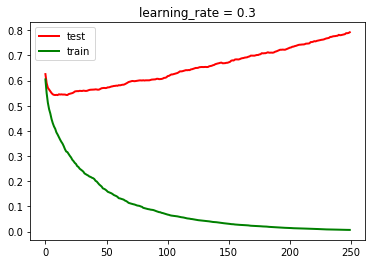

      Iter       Train Loss   Remaining Time 
         1           1.2613           15.44s
         2           1.1715           14.88s
         3           1.1009           14.66s
         4           1.0529           14.76s
         5           1.0130           14.90s
         6           0.9740           14.80s
         7           0.9475           14.30s
         8           0.9197           14.43s
         9           0.8979           14.14s
        10           0.8730           14.06s
        20           0.7207           12.27s
        30           0.6055           11.56s
        40           0.5244           11.11s
        50           0.4501           10.45s
        60           0.3908            9.82s
        70           0.3372            9.36s
        80           0.3009            9.16s
        90           0.2603            9.06s
       100           0.2327            8.65s
       200           0.0835            2.64s


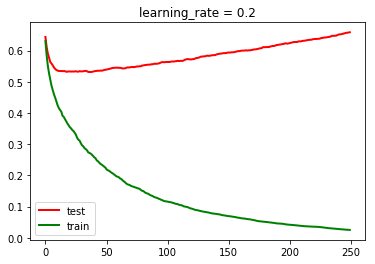

      Iter       Train Loss   Remaining Time 
         1           1.3199           15.44s
         2           1.2645           15.25s
         3           1.2170           15.23s
         4           1.1775           15.68s
         5           1.1404           15.39s
         6           1.1106           15.29s
         7           1.0844           15.27s
         8           1.0617           15.37s
         9           1.0411           15.37s
        10           1.0223           15.19s
        20           0.8864           13.79s
        30           0.7844           12.42s
        40           0.7176           11.43s
        50           0.6590           10.61s
        60           0.6120            9.95s
        70           0.5599            9.34s
        80           0.5242            8.71s
        90           0.4829            8.19s
       100           0.4473            7.65s
       200           0.2379            2.55s


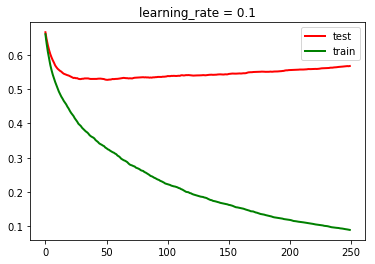

In [10]:
min_loss_results = {}
for learning_rate in [1, 0.5, 0.3, 0.2, 0.1]:
    min_loss_results[learning_rate] = model_test(learning_rate)

Определим минимальное значение log-loss и номер итерации, на котором оно достигается, при learning_rate = 0.2

In [11]:
min_loss_value, min_loss_index = min_loss_results[0.2]
print(min_loss_value, min_loss_index)

(0.53145079631906378, 36)


Обучим RandomForestClassifier с количеством деревьев, равным количеству итераций, на котором достигается наилучшее качество у градиентного бустинга из предыдущего пункта.
Определим  log-loss на тесте

In [12]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=min_loss_index, random_state=241)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
test_loss = log_loss(y_test, y_pred)


In [13]:
test_loss

0.54138128618040693